In [88]:
import json
import timeit, time
from functools import partial
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
from pathlib import Path
import math

# Not Your Grandma's Review Analyzer

## COSC 320 - Milestone 4

### Team Members

Quinn Marshall, Archita Gattani, and Connor Doman

## Algorithm

### Importing Data

Our algorithm requires us to read from a JSON file. We load that here.

In [89]:
DATA_FILE_FOLDER = '../data/raw/'
DATA_FILE_NAME = 'sports_and_outdoors_reviews'
DATA_FILE_TYPE = '.json'
DATA_FILE_PATH = Path(DATA_FILE_FOLDER + DATA_FILE_NAME + DATA_FILE_TYPE)

def get_reviews_from_sports_data():    
    sports_data = []
    start = time.time()
    with open(Path(DATA_FILE_FOLDER + DATA_FILE_NAME + '_million' + DATA_FILE_TYPE), 'r') as f:
        sports_data = json.load(f)
    end = time.time()

    print(f"Got {len(sports_data)} reviews in {end - start:.2f}s")

    total_review_size = 0
    review_text = []
    for i, r in enumerate(sports_data):
        if 'reviewText' in r:
            total_review_size += len(r['reviewText'])
            review_text.append(r['reviewText'])
    average_review_length = math.ceil(total_review_size / len(review_text))
    print(f"Average review length: {average_review_length} characters")

    return (review_text, average_review_length, total_review_size)

### Algorithm 2

The following is an implementation of our second algorithm. We start by declaring a dictionary of translations. 

In [90]:

REPLACEMENT_DICTIONARY = {
    "the": "THE",
    "hello": "hi",
    "fun": "TERRIBLE",
    "how": "what",
    "are": "COSC322",
    "you": "me"
}


class TrieNode:
    def __init__(self):
        self.children = {}
        self.end_of_word = False
# end of class TrieNode

class Trie:
    def __init__(self):
        self.root = TrieNode()
        self.operations = 0

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                self.operations += 1
                node.children[char] = TrieNode()
            node = node.children[char]
        node.end_of_word = True

    def replace_all(self, T, t=REPLACEMENT_DICTIONARY):
        words = T.split(" ")
        self.operations += len(words) # one operation for each word

        for i, word in enumerate(words):
            node = self.root
            for j, char in enumerate(word):
                if char not in node.children:
                    break
                node = node.children[char]
                if node.end_of_word:
                    words[i] = t.get(word, word)
                    self.operations += 1
                    break
        return " ".join(words), self.operations
# end of class Trie


# Algorithm 2
def create_trie_from_dictionary():
    t = Trie()
    for word in REPLACEMENT_DICTIONARY.keys():
        t.insert(word)
    # for word in text.split(" "):
    #     t.insert(word)
    return t

### Asymptotic Analysis

The following code pulls the review data from the JSON file and loads the main body of each review into a list.

In [91]:
REVIEWS, AVERAGE_REVIEW_LENGTH, TOTAL_REVIEW_SIZE = get_reviews_from_sports_data() # 999999 reviews

Got 999999 reviews in 4.20s
Average review length: 246 characters



Below is a function that will time our algorithm in increasing steps of `nInc`, each timing of length `nTests`.

In order to capture the value returned by our function after each test, we must first modify the `timeit` library's test template:

In [102]:
def calculate_time_complexity(fn, n_min, n_max, n_inc, samples, arguments=[]):
    """
    Run timer and plot time complexity
    """
    if n_min > n_max:
        raise ValueError("nMin must be less than nMax")

    if len(samples) == 0:
        raise ValueError("samples must be a list of strings")

    if n_max < len(samples):
        samples = samples[:n_max]

    print(f"Testing '{fn.__name__}' from input {n_min} to {n_max} in steps of {n_inc}...")
    
    start = time.time() # start counting total time
    x = []
    y = []
    for i in range(n_min, n_max, n_inc):
        args = arguments.copy()
        N = i
        args.insert(0, N)
        # test_N_timer = timeit.Timer(partial(fn, *args)) # our algorithm is called here

        # t, ops = test_N_timer.timeit(number=n_tests) # retrieve time and number of characters
        ops = partial(fn, *args)()
        print(f"{fn.__name__}: Input size={N}, Operations={ops}")
        x.append(N * AVERAGE_REVIEW_LENGTH)
        y.append(ops)
        
    end = time.time() # stop counting total time
    print(f"{fn.__name__} took {end - start:.2f}s") # print total time

    df = pd.DataFrame({'x': x, 'y': y})
    display(df.head())
    return df

In [93]:
def plot(df, title, x_label, y_label):
    """
    Plot time complexity
    """
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=df, x="x", y="y")
    pl.title(title)
    pl.xlabel(x_label)
    pl.ylabel(y_label)
    pl.show()

In [104]:
def test_algorithm_2(N):
    """
    Combines all the reviews in the sample into one mega string to be passed to replace_with_new_word
    """
    start = time.time() # start counting total time

    reviews_array_temp = REVIEWS[:N]
    mega_string = " ".join(reviews_array_temp)
    # text, operations = replace_with_new_word(mega_string) # our algorithm
    text, operations = create_trie_from_dictionary().replace_all(mega_string)

    end = time.time() # stop counting total time
    # print(f"test_algorithm_2(N={N}, samples={len(reviews_array_temp)}, length={len(mega_string)}): {end - start:.2f}s") # print total time
    return operations

### Testing

To save time, we will only test the first 1000 reviews. We will also load the script only once.

### Comparison

We estimated our algorithm would run in `O(nm)` time, how does it compare to the literal function `f(n, m)`?

In [95]:
def fn_linear(n):
    """
    O(n) function
    """
    ops = 0
    for i in range(n):
        ops += AVERAGE_REVIEW_LENGTH
    return n


def fn_squared(n):
    """
    O(n^2) function
    """
    ops = 0
    for i in range(n):
        for j in range(n):
            x = i*j
            ops += AVERAGE_REVIEW_LENGTH
    return ops


def fn_multiple(n, m):
    """
    O(nm) function
    """
    ops = 0
    for i in range(n):
        for j in range(m):
            x = i*j
            ops += AVERAGE_REVIEW_LENGTH
    # print(f"{__name__} for n={n}, m={m}...(n*m={n*m}) ops={ops}")
    return ops

In [96]:
def plot(df, title, x_label, y_label):
    """
    Plot time complexity
    """
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=df, x="operations", y="value", hue="variable")
    pl.title(title)
    pl.xlabel(x_label)
    pl.ylabel(y_label)
    pl.legend(loc='upper left', title='Algorithm')
    pl.ticklabel_format(style='plain', axis='y')
    pl.show()

Testing 'fn_linear' from input 1 to 50 in steps of 1...
fn_linear: Input size=1, Operations=1
fn_linear: Input size=2, Operations=2
fn_linear: Input size=3, Operations=3
fn_linear: Input size=4, Operations=4
fn_linear: Input size=5, Operations=5
fn_linear: Input size=6, Operations=6
fn_linear: Input size=7, Operations=7
fn_linear: Input size=8, Operations=8
fn_linear: Input size=9, Operations=9
fn_linear: Input size=10, Operations=10
fn_linear: Input size=11, Operations=11
fn_linear: Input size=12, Operations=12
fn_linear: Input size=13, Operations=13
fn_linear: Input size=14, Operations=14
fn_linear: Input size=15, Operations=15
fn_linear: Input size=16, Operations=16
fn_linear: Input size=17, Operations=17
fn_linear: Input size=18, Operations=18
fn_linear: Input size=19, Operations=19
fn_linear: Input size=20, Operations=20
fn_linear: Input size=21, Operations=21
fn_linear: Input size=22, Operations=22
fn_linear: Input size=23, Operations=23
fn_linear: Input size=24, Operations=24
fn

,x,y
0,246,1
1,492,2
2,738,3
3,984,4
4,1230,5


Testing 'fn_multiple' from input 1 to 50 in steps of 1...
fn_multiple: Input size=1, Operations=1476
fn_multiple: Input size=2, Operations=2952
fn_multiple: Input size=3, Operations=4428
fn_multiple: Input size=4, Operations=5904
fn_multiple: Input size=5, Operations=7380
fn_multiple: Input size=6, Operations=8856
fn_multiple: Input size=7, Operations=10332
fn_multiple: Input size=8, Operations=11808
fn_multiple: Input size=9, Operations=13284
fn_multiple: Input size=10, Operations=14760
fn_multiple: Input size=11, Operations=16236
fn_multiple: Input size=12, Operations=17712
fn_multiple: Input size=13, Operations=19188
fn_multiple: Input size=14, Operations=20664
fn_multiple: Input size=15, Operations=22140
fn_multiple: Input size=16, Operations=23616
fn_multiple: Input size=17, Operations=25092
fn_multiple: Input size=18, Operations=26568
fn_multiple: Input size=19, Operations=28044
fn_multiple: Input size=20, Operations=29520
fn_multiple: Input size=21, Operations=30996
fn_multiple:

,x,y
0,246,1476
1,492,2952
2,738,4428
3,984,5904
4,1230,7380


Testing 'fn_squared' from input 1 to 50 in steps of 1...
fn_squared: Input size=1, Operations=246
fn_squared: Input size=2, Operations=984
fn_squared: Input size=3, Operations=2214
fn_squared: Input size=4, Operations=3936
fn_squared: Input size=5, Operations=6150
fn_squared: Input size=6, Operations=8856
fn_squared: Input size=7, Operations=12054
fn_squared: Input size=8, Operations=15744
fn_squared: Input size=9, Operations=19926
fn_squared: Input size=10, Operations=24600
fn_squared: Input size=11, Operations=29766
fn_squared: Input size=12, Operations=35424
fn_squared: Input size=13, Operations=41574
fn_squared: Input size=14, Operations=48216
fn_squared: Input size=15, Operations=55350
fn_squared: Input size=16, Operations=62976
fn_squared: Input size=17, Operations=71094
fn_squared: Input size=18, Operations=79704
fn_squared: Input size=19, Operations=88806
fn_squared: Input size=20, Operations=98400
fn_squared: Input size=21, Operations=108486
fn_squared: Input size=22, Operatio

,x,y
0,246,246
1,492,984
2,738,2214
3,984,3936
4,1230,6150


Testing 'test_algorithm_2' from input 1 to 50 in steps of 1...
test_algorithm_2: Input size=1, Operations=178
test_algorithm_2: Input size=2, Operations=186
test_algorithm_2: Input size=3, Operations=322
test_algorithm_2: Input size=4, Operations=375
test_algorithm_2: Input size=5, Operations=376
test_algorithm_2: Input size=6, Operations=388
test_algorithm_2: Input size=7, Operations=427
test_algorithm_2: Input size=8, Operations=465
test_algorithm_2: Input size=9, Operations=548
test_algorithm_2: Input size=10, Operations=596
test_algorithm_2: Input size=11, Operations=623
test_algorithm_2: Input size=12, Operations=661
test_algorithm_2: Input size=13, Operations=668
test_algorithm_2: Input size=14, Operations=954
test_algorithm_2: Input size=15, Operations=1007
test_algorithm_2: Input size=16, Operations=1016
test_algorithm_2: Input size=17, Operations=1136
test_algorithm_2: Input size=18, Operations=1137
test_algorithm_2: Input size=19, Operations=1330
test_algorithm_2: Input size=

,x,y
0,246,178
1,492,186
2,738,322
3,984,375
4,1230,376


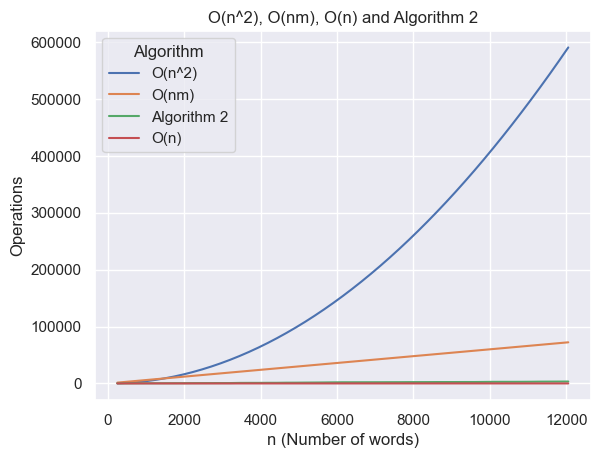

In [105]:
n = 50
m = len(REPLACEMENT_DICTIONARY.keys())
r = AVERAGE_REVIEW_LENGTH
increments = 1

fn_line = calculate_time_complexity(fn_linear, 1, n, increments, samples=REVIEWS)
fn_multi = calculate_time_complexity(fn_multiple, 1, n, increments, samples=REVIEWS, arguments=[m])
fn_square = calculate_time_complexity(fn_squared, 1, n, increments, samples=REVIEWS)
fn_algorithm = calculate_time_complexity(test_algorithm_2, 1, n, increments, samples=REVIEWS)

df = pd.DataFrame({'operations': fn_algorithm['x'], 'O(n^2)': fn_square['y'], 'O(nm)': fn_multi['y'], 'Algorithm 2': fn_algorithm['y'], 'O(n)': fn_line['y']})

final_df = pd.melt(df, ['operations'])

plot(final_df, f"O(n^2), O(nm), O(n) and Algorithm 2", "n (Number of words)", "Operations")